In [1]:
import sys
sys.path.append("/s/ls4/users/grartem/RL_robots/continuous-grid-arctic/src")
sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
os.chdir("/s/ls4/users/grartem/RL_robots/RL_robotSim/")

In [3]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
import MyTfModel
import MyNewModels
%matplotlib inline

import MyMisc

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Prepare env and model

In [4]:
configs = pyhocon.ConfigFactory.parse_file("/s/ls4/users/grartem/RL_robots/RL_robotSim/Configs/FollowerContinuous/PPO_dyn_obst_2.conf")
#CONFIG = configs["ppo_e28_b1_f14v2_prev5_m_trans_v4v2"].as_plain_ordered_dict()
CONFIG = configs["ppo_e29_b2_f14VPC_mv4"].as_plain_ordered_dict()
CONFIG["config"]["num_workers"]=1

In [5]:
import json
with open("/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_test_sensors/env29/PPO/default_model/feats_v14VPC/bear2/ppo_e29_b2_f14VPC_mv4_backup/PPO_continuous-grid_399ae_00000_0_2023-07-21_14-24-58/params.json", "r") as f:
    CONFIG = json.load(f)

In [30]:
CONFIG["env_config"]["base_env_config"]

{'add_bear': True,
 'add_obstacles': True,
 'bear_behind': False,
 'bear_number': 2,
 'bear_speed_coeff': 1.2,
 'constant_follower_speed': False,
 'corridor_length': 10,
 'corridor_width': 1.5,
 'early_stopping': {'low_reward': -300, 'max_distance_coef': 3.5},
 'follower_sensors': {'LaserPrevSensor_compas': {'back_lasers_count': 12,
   'front_lasers_count': 12,
   'laser_length': 200,
   'react_to_green_zone': False,
   'react_to_obstacles': True,
   'react_to_safe_corridor': False,
   'sensor_name': 'LaserPrevSensor_compas'},
  'LeaderCorridor_Prev_lasers_v2_compas': {'back_lasers_count': 6,
   'front_lasers_count': 6,
   'laser_length': 150,
   'react_to_green_zone': True,
   'react_to_obstacles': True,
   'react_to_safe_corridor': True,
   'sensor_name': 'LeaderCorridor_Prev_lasers_v2_compas'},
  'LeaderPositionsTracker_v2': {'eat_close_points': False,
   'generate_corridor': True,
   'saving_period': 8,
   'sensor_name': 'LeaderPositionsTracker_v2',
   'start_corridor_behind_follow

In [6]:
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LeaderPositionsTracker_v2"]["sensor_class"] = 'LeaderPositionsTracker_v2'
#CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LeaderPositionsTracker_v2"].pop("sensor_name")
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"].pop('LeaderCorridor_Prev_lasers_v2_compas')
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"].pop('LaserPrevSensor_compas')
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LaserPrevSensor_v2_compas_all"] = {
                                 "sensor_class": "LaserPrevSensor_v2_compas",
                                 "react_to_obstacles": True,
                                 "front_lasers_count": 6,
                                 "back_lasers_count": 6,
                                 "react_to_safe_corridor": True,
                                 "react_to_green_zone": True,
                                 "laser_length": 150,
                                 "use_prev_obs": True,
                                 "max_prev_obs": 5,
                                 "pad_sectors": False
}
CONFIG["config"]["env_config"]["base_env_config"]["follower_sensors"]["LaserPrevSensor_v2_compas_obst"] = {
                                 "sensor_class": "LaserPrevSensor_v2_compas",
                                 "react_to_obstacles": True,
                                 "front_lasers_count": 12,
                                 "back_lasers_count": 12,
                                 "react_to_safe_corridor": False,
                                 "react_to_green_zone": False,
                                 "laser_length": 200,
                                 "use_prev_obs": True,
                                 "max_prev_obs": 5,
                                 "pad_sectors": False
}
CONFIG["config"]["env_config"]["use_prev_obs"] = True
CONFIG["config"]["env_config"]["max_prev_obs"] = 5

KeyError: 'config'

In [7]:
EXPERIMENT_DIR = "/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_test_sensors/env29/PPO/default_model/feats_v14VPC/bear2/ppo_e29_b2_f14VPC_mv4_backup/PPO_continuous-grid_399ae_00000_0_2023-07-21_14-24-58/"
checkpoint_path = EXPERIMENT_DIR + "/checkpoint_000300/checkpoint-300"


In [10]:
#trainer = ray.rllib.agents.registry.get_trainer_class(CONFIG["run"])(CONFIG["config"])
trainer = ray.rllib.agents.registry.get_trainer_class("PPO")(CONFIG)
trainer.restore(checkpoint_path)

#env = MyMisc.continuous_env_maker(config=CONFIG["config"]["env_config"])
env = MyMisc.continuous_env_maker(config=CONFIG["env_config"])

(RolloutWorker pid=6199) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=6199) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=6193) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=6193) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=6196) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=6196) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=6157) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=6157) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=6199) ===Запуск симуляции номер 0===


(RolloutWorker pid=6199) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:340: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=6199)   warn(
(RolloutWorker pid=6199) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=6199)   logger.warn(
(RolloutWorker pid=6193) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:340: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=6193)   warn(
(RolloutWorker pid=6193) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered 

(RolloutWorker pid=6193) ===Запуск симуляции номер 0===
(RolloutWorker pid=6157) ===Запуск симуляции номер 0===
(RolloutWorker pid=6196) ===Запуск симуляции номер 0===


(RolloutWorker pid=6196) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:340: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=6196)   warn(
(RolloutWorker pid=6196) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=6196)   logger.warn(
(RolloutWorker pid=6199) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=6199) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=6199) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=6199) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=6199) ALSA lib conf.c:456

(RolloutWorker pid=6199) Model: "model"
(RolloutWorker pid=6199) __________________________________________________________________________________________________
(RolloutWorker pid=6199) Layer (type)                    Output Shape         Param #     Connected to                     
(RolloutWorker pid=6199) ==================================================================================================
(RolloutWorker pid=6199) observations (InputLayer)       [(None, 5, 144)]     0                                            
(RolloutWorker pid=6199) __________________________________________________________________________________________________
(RolloutWorker pid=6199) flatten (Flatten)               (None, 720)          0           observations[0][0]               
(RolloutWorker pid=6199) __________________________________________________________________________________________________
(RolloutWorker pid=6199) my_layer2 (Dense)               (None, 256)          184576      fl

(RolloutWorker pid=6199) 2023-08-02 15:02:23,219	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=6199) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 144)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 720)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          184576      flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792   

(RolloutWorker pid=6193) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=6193) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=6193) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=6193) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=6193) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
(RolloutWorker pid=6193) ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
(RolloutWorker pid=6193) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
(RolloutWorker pid=6193) ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
(RolloutWorker pid=6193) ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default


(RolloutWorker pid=6193) Model: "model"
(RolloutWorker pid=6193) __________________________________________________________________________________________________
(RolloutWorker pid=6193) Layer (type)                    Output Shape         Param #     Connected to                     
(RolloutWorker pid=6193) ==================================================================================================
(RolloutWorker pid=6193) observations (InputLayer)       [(None, 5, 144)]     0                                            
(RolloutWorker pid=6193) __________________________________________________________________________________________________
(RolloutWorker pid=6193) flatten (Flatten)               (None, 720)          0           observations[0][0]               
(RolloutWorker pid=6193) __________________________________________________________________________________________________
(RolloutWorker pid=6193) my_layer2 (Dense)               (None, 256)          184576      fl

(RolloutWorker pid=6157) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=6157) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=6157) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=6157) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=6157) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
(RolloutWorker pid=6157) ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
(RolloutWorker pid=6157) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
(RolloutWorker pid=6157) ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
(RolloutWorker pid=6157) ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
(RolloutWorker pid

(RolloutWorker pid=6157) Model: "model"
(RolloutWorker pid=6157) __________________________________________________________________________________________________
(RolloutWorker pid=6157) Layer (type)                    Output Shape         Param #     Connected to                     
(RolloutWorker pid=6157) ==================================================================================================
(RolloutWorker pid=6157) observations (InputLayer)       [(None, 5, 144)]     0                                            
(RolloutWorker pid=6157) __________________________________________________________________________________________________
(RolloutWorker pid=6157) flatten (Flatten)               (None, 720)          0           observations[0][0]               
(RolloutWorker pid=6157) __________________________________________________________________________________________________
(RolloutWorker pid=6157) my_layer2 (Dense)               (None, 256)          184576      fl

2023-08-02 15:02:26,749	INFO trainable.py:124 -- Trainable.setup took 17.392 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-08-02 15:02:26,754	WARNING util.py:57 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=6196) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>
(RolloutWorker pid=6157) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>


2023-08-02 15:02:26,929	INFO trainable.py:467 -- Restored on 172.19.8.131 from checkpoint: /s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_test_sensors/env29/PPO/default_model/feats_v14VPC/bear2/ppo_e29_b2_f14VPC_mv4_backup/PPO_continuous-grid_399ae_00000_0_2023-07-21_14-24-58//checkpoint_000300/checkpoint-300
2023-08-02 15:02:26,934	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': 0, '_time_total': 120035.09275317192, '_episodes_total': 16531}
/s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:340: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
  warn(
/s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [11]:
policy = trainer.get_policy()
print(type(policy))
print(type(policy.model))

<class 'ray.rllib.policy.tf_policy_template.PPOTFPolicy'>
<class 'MyNewModels.DefaultModelPrev'>


In [12]:
policy.model.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 5, 144)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 720)          0           observations[0][0]               
__________________________________________________________________________________________________
my_layer2 (Dense)               (None, 256)          184576      flatten[0][0]                    
__________________________________________________________________________________________________
my_layer1 (Dense)               (None, 256)          65792       my_layer2[0][0]                  
______________________________________________________________________________________________

# Test episode

In [24]:
# Start env episode
seed_i = 194
env.seed(seed_i)
obs = env.reset()
done = False
total_reward = 0.0

===Запуск симуляции номер 1===


In [25]:
# run N steps
NNobs_history, raw_obs_history, reward_history, info_history, actions_hist = [], [], [], [], []
obs_history = []
start_time = time.time()
for i in range(1000):
    # Compute a single action, given the current observation
    # from the environment.
    NNobs_history.append(obs)
    raw_obs = env.env.env._get_obs()
    raw_obs_history.append({
        #'LeaderTrackDetector_radar': raw_obs['LeaderTrackDetector_radar'],
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        "numerical_features": raw_obs["numerical_features"]
    })
    
    pred_result = trainer.compute_single_action(obs, explore=False, full_fetch=True)
    action = pred_result[0]
    # Apply the computed action in the environment.
    obs, reward, done, info = env.step(action)
    #obs, reward, done, info = env.step([0.9, 0.0])
    obs_history.append(obs)
    
    actions_hist.append(action)
    reward_history.append(reward)
    info_history.append(info)
    # Sum up rewards for reporting purposes.
    total_reward += reward
    if done:
        break
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(elapsed_time)
#1:19

00:00:46


In [26]:
import joblib
raw_obs_history_new = joblib.dump(raw_obs_history, "raw_obs_history.joblib")
NNobs_history_new = joblib.dump(NNobs_history, "NNobs_history.joblib")

In [23]:
!pwd

/s/ls4/users/grartem/RL_robots/RL_robotSim


In [17]:

raw_obs_history_old = joblib.load("raw_obs_history.old")
NNobs_history_old = joblib.load("NNobs_history.old")

In [15]:
len(NNobs_history)

600

In [27]:
NNobs_history[7]

array([[0.7637027 , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.66099045, 0.50792709, 0.52710515, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.48370473, 0.37169515, 0.38572919, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55557048, 0.51094309, 0.53023453, 1.        , 1.        ,
        1.        , 0.84502716, 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

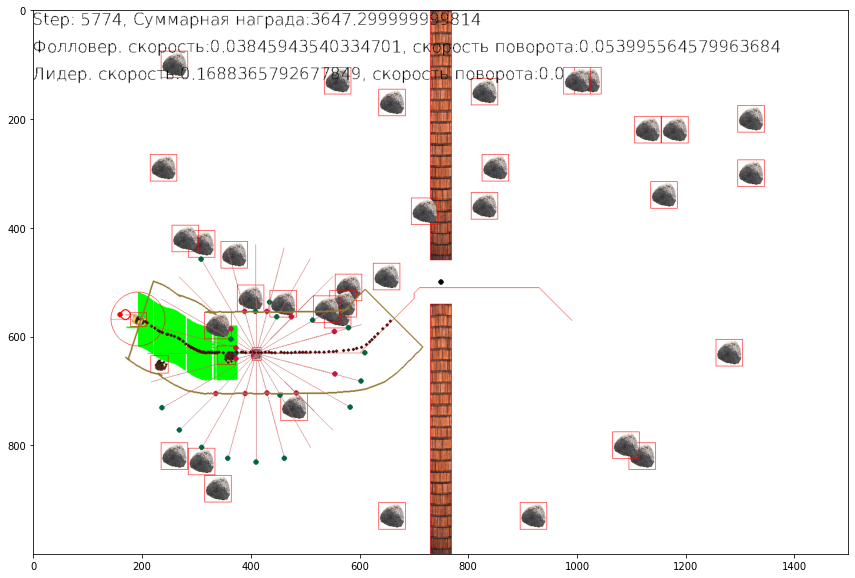

In [28]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

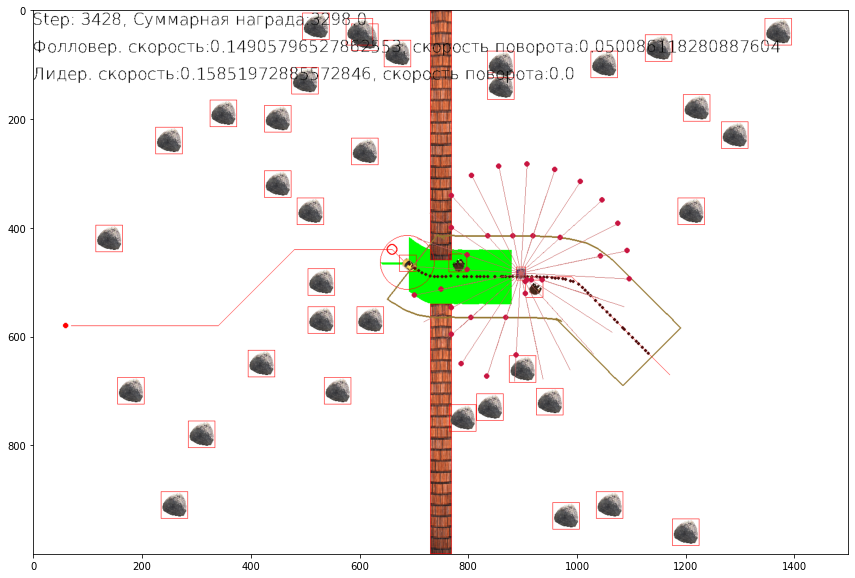

In [32]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [169]:
env.follower.rectangle.center, env.follower.position, env.env.env.game_dynamic_list[0].rectangle.center, env.env.env.game_dynamic_list[0].position

((1345, 743), array([1012.,  680.]), (1040, 530), (1340.0, 530.0))

In [ ]:
env.follower.rectangle.move()

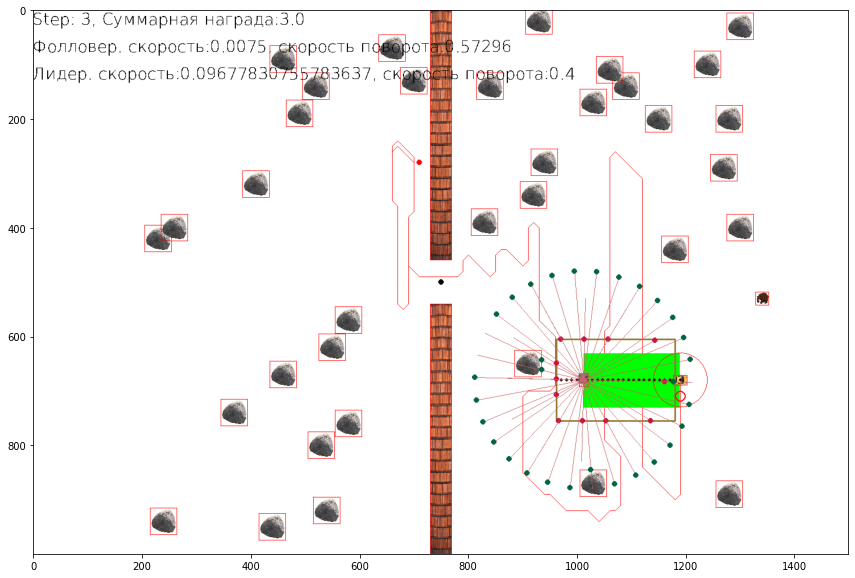

In [14]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))